In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
# Pfad für die Directory
directory_path = "../models/xgboost"

# Erstelle die Directory, falls sie nicht existiert
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' wurde erstellt.")
else:
    print(f"Directory '{directory_path}' existiert bereits.")


Directory '../models/xgboost' existiert bereits.


In [3]:
# Example of loading data into a pandas DataFrame (replace with your actual data loading)
df = pd.read_csv('../data/tmp/encoded_train.csv')
test_df = pd.read_csv('../data/tmp/encoded_test.csv')

# Display the first few rows of the dataframe
df.head()


,Day,Month,Hour,Night,Holiday,Block,lat,long,Category,DayOfWeek-Monday,...,StreetType-LN,StreetType-DR,StreetType-CT,StreetType-WAY,StreetType-RW,StreetType-PZ,Season-Winter,Season-Fall,Season-Spring,Season-Summer
0,29,11,0,1,0,0,0.584478,-1.557336,OTHER OFFENSES,0,...,0,0,0,0,0,0,0,1,0,0
1,1,6,8,0,0,1,0.911468,0.775401,OTHER OFFENSES,0,...,0,0,0,0,0,0,0,0,0,1
2,27,4,6,0,0,1,-2.045603,0.570183,OTHER OFFENSES,0,...,0,0,0,0,0,0,0,0,1,0
3,1,4,15,0,0,32,1.510611,-0.150875,ASSAULT,0,...,0,0,0,0,0,0,0,0,1,0
4,25,7,16,0,0,0,0.718501,0.532851,ASSAULT,0,...,0,0,0,0,0,0,0,0,0,1


In [4]:
label_encoder = LabelEncoder()
df['Category'] = label_encoder.fit_transform(df['Category'])
test_df['Category'] = label_encoder.transform(test_df['Category'])

# Save fitted label encoder
joblib.dump(label_encoder, "../models/xgboost/label_encoder.joblib")

['../models/xgboost/label_encoder.joblib']

In [5]:
# Define features (X) and target (y)
X = df.drop('Category', axis=1)  # Features: all columns except 'Category'
y = df['Category'] 

x_test = test_df.drop('Category', axis=1) # Features: all columns except 'Category'
y_test = test_df['Category']


In [6]:
model = XGBClassifier(
    n_estimators=150, 
    objective="multi:softprob", 
    random_state=42,
    colsample_bytree=0.8,
    gamma=0.5,
    learning_rate=0.1,
    max_depth=50,
    subsample=1.0,
    n_jobs=8
)

In [7]:
# Fitting the model
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=50, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=8,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [8]:
# Get feature importance
feature_importance = model.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                  Feature  Importance
21  PdDistrict-TENDERLOIN    0.153047
34         StreetType-INT    0.114764
19     PdDistrict-BAYVIEW    0.032275
15     PdDistrict-MISSION    0.027325
23     PdDistrict-CENTRAL    0.026349
22        PdDistrict-PARK    0.022272
3                   Night    0.021981
24     PdDistrict-TARAVAL    0.020957
5                   Block    0.020291
16    PdDistrict-SOUTHERN    0.019970
20    PdDistrict-RICHMOND    0.019788
44          StreetType-PZ    0.019744
18   PdDistrict-INGLESIDE    0.019676
17    PdDistrict-NORTHERN    0.018580
40          StreetType-DR    0.018508
6                     lat    0.018114
7                    long    0.017778
26        StreetType-I-80    0.017280
32          StreetType-AV    0.016753
29          StreetType-ST    0.016165
39          StreetType-LN    0.015900
30          StreetType-BL    0.015450
2                    Hour    0.015446
27          StreetType-WY    0.014573
28          StreetType-HY    0.013782
10       Day

## Evaluation

### Accuracy on **train dataset**

In [9]:
y_train_pred = model.predict(X)

accuracy = accuracy_score(y, y_train_pred)
print(f"Accuracy for train dataset: {accuracy}")

Accuracy for train dataset: 0.7802900469902951


### Accuracy

In [10]:
# Predict on the test data
y_pred = model.predict(x_test)

In [11]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.3080519332612038


### Precision and Recall per class

In [12]:
precision_scores = precision_score(y_test, y_pred, average=None)
recall_scores = recall_score(y_test, y_pred, average=None)
f1_scores = f1_score(y_test, y_pred, average=None)

# Round scores
precision_scores = [round(score, 2) for score in precision_scores]
recall_scores = [round(score, 2) for score in recall_scores]
f1_scores = [round(score, 2) for score in f1_scores]

classes = model.classes_

precision_df = pd.DataFrame({
    'Class': label_encoder.inverse_transform(classes),
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1': f1_scores
})

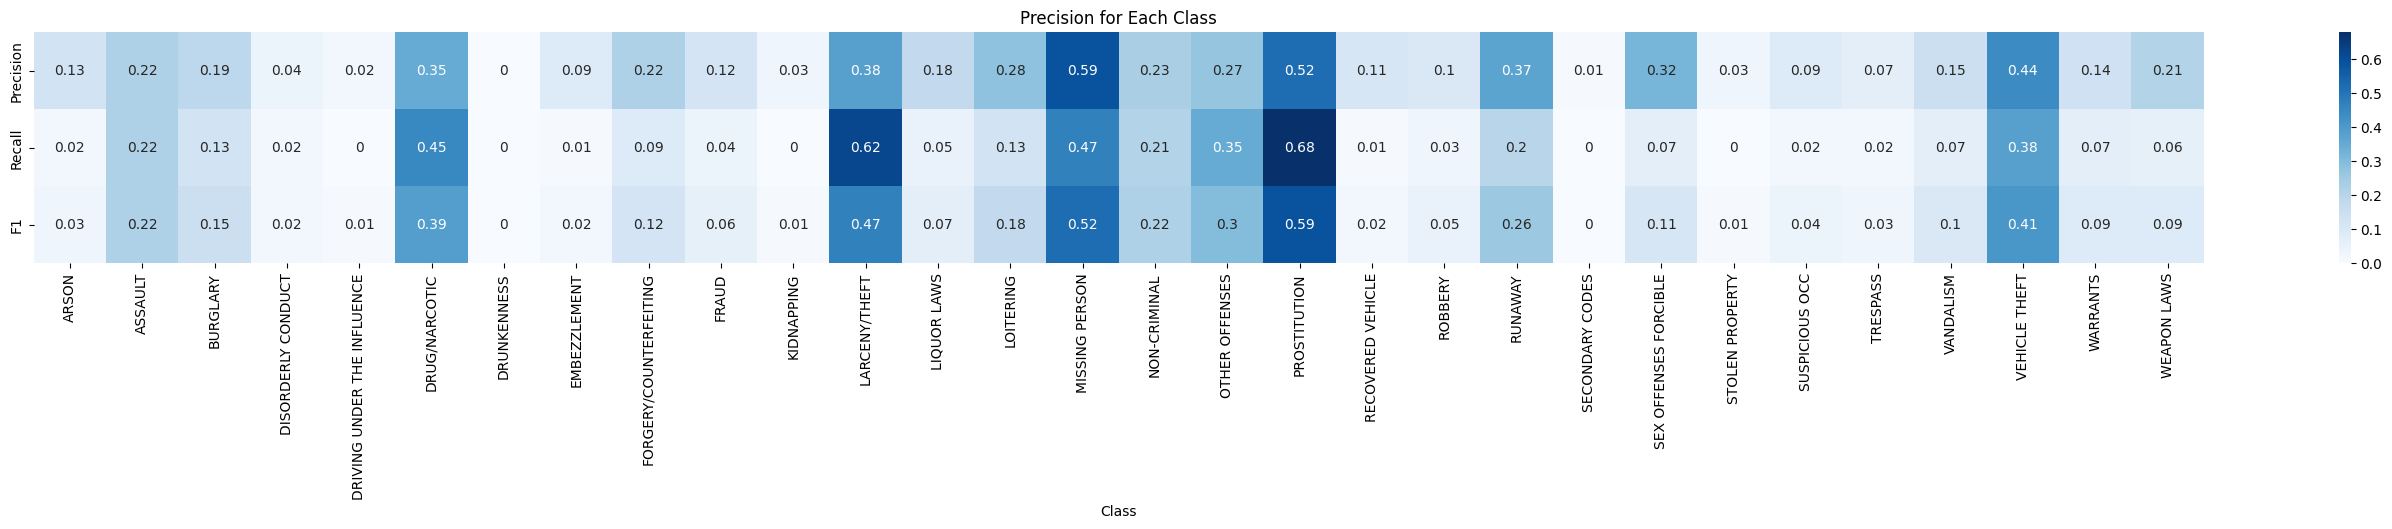

In [13]:
# Plot the DataFrame as a heatmap
plt.figure(figsize=(35, 3))
sns.heatmap(precision_df.set_index('Class').T, annot=True, cmap="Blues")
plt.title('Precision for Each Class')
plt.savefig('../models/xgboost/scores_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

### Balenced Accuracy

In [14]:
recall_sum = sum(recall_scores)
amount_of_classes = len(recall_scores)
balenced_accuracy = recall_sum / amount_of_classes
print(f"Balenced Accuracy Score: {balenced_accuracy}")

Balenced Accuracy Score: 0.14733333333333334


In [15]:
accuracy = balanced_accuracy_score(y_test, y_pred)
print(accuracy)

0.14790366399074437


### Precision / Recall Average

In [16]:
precision_avg = precision_score(y_test, y_pred, average='weighted')
recall_avg = recall_score(y_test, y_pred, average='weighted')
f1_avg = f1_score(y_test, y_pred, average='weighted')

print(f"Weighted average for precision: {round(precision_avg, 2)}")
print(f"Weighted average for recall: {round(recall_avg, 2)}")
print(f"Weighted average for f1: {round(f1_avg, 2)}")

Weighted average for precision: 0.27
Weighted average for recall: 0.31
Weighted average for f1: 0.28


### Log Loss

In [17]:
y_pred_proba = model.predict_proba(x_test)

In [18]:
label_binarizer = LabelBinarizer()
labelTransformed = label_binarizer.fit_transform(y_test)

df = pd.DataFrame(y_pred_proba, columns=model.classes_)
df = df[label_binarizer.classes_]

loss = log_loss(labelTransformed, df)
print(f'Log Loss: {loss}')

Log Loss: 2.3229740643574837


In [19]:
y_test = label_encoder.inverse_transform(y_test)
y_pred = label_encoder.inverse_transform(y_pred)

### Normalized Confusion Matrix

In [20]:
cnf_matrix = confusion_matrix(y_test, y_pred)

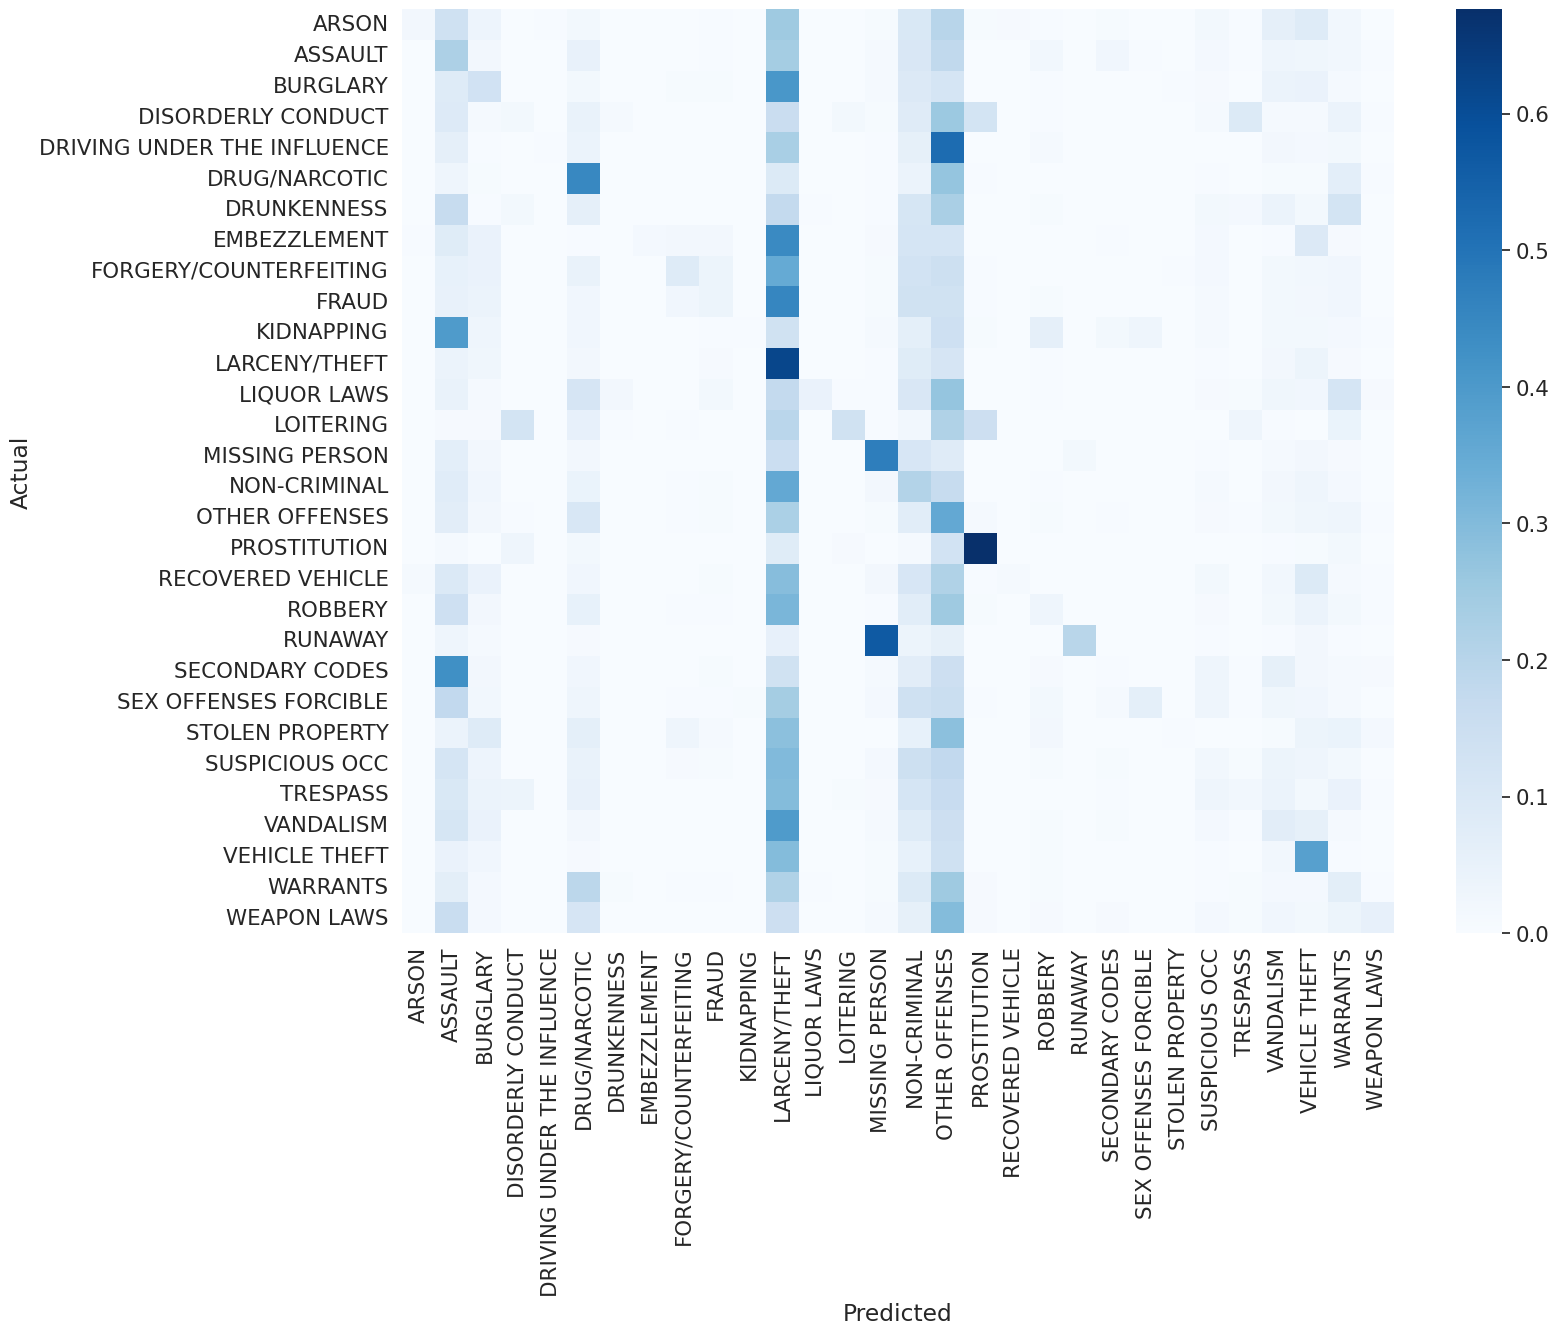

In [21]:
cnf_normalized = cnf_matrix / np.sum(cnf_matrix, axis=1).reshape(-1,1)


df_cm = pd.DataFrame(cnf_normalized, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

plt.figure(figsize = (16,12))
plt.tight_layout()
sns.set(font_scale=1.4)  # for label size

# Plot the normalized confusion matrix
sns.heatmap(df_cm, cbar=True, cmap= "Blues", annot=False, fmt='.0f' #, annot_kws={"size": 13}
           )
plt.savefig('../models/xgboost/confusion_matrix.png', dpi=300, bbox_inches='tight')

In [22]:
# Save the model
joblib.dump(model, '../models/xgboost/xgboost.pkl')

['../models/xgboost/xgboost.pkl']